# Part 2: Longitudinal Repeatability in phantom and in vivo at one site

# Before starting 

We import the main libraries we'll use and we define a function to read cfl files:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import pandas as pd
import nibabel as nib
import glob
import os
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

def read_cfl(file_path):
    """
    Reads a CFL (Complex Float) data file.
    
    Parameters:
    file_path (str): Path to the .cfl file (without extension).
    
    Returns:
    np.ndarray: The complex float data as a numpy array.
    """
    with open(file_path + '.hdr', 'r') as hdr_file:
        hdr_file.readline()  
        dims = list(map(int, hdr_file.readline().strip().split()))
    num_elements = np.prod(dims)
    with open(file_path + '.cfl', 'rb') as cfl_file:
        data = np.fromfile(cfl_file, dtype=np.complex64, count=num_elements)
    data = data.reshape(dims, order='F')  
    return data

## Figure 3

This figure is generated using the data from a volunteer. For privacy reason, we cannot share the image, but here's the code to generate the figure.
Part a. of the figure is generated using:

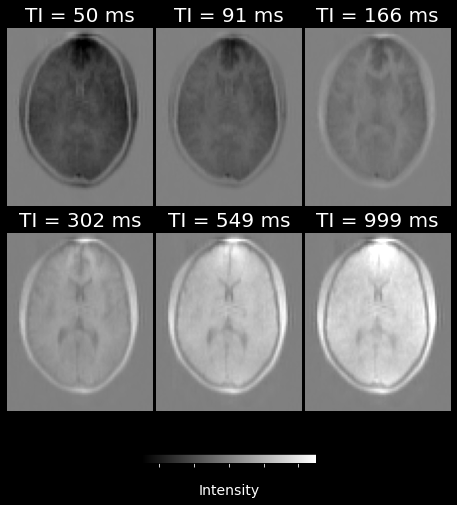

In [4]:
# List of TI values (in milliseconds)
TI_values = [50, 91, 166, 302, 549, 999]

# Read the T1w images 
filename = r'../../path/to/image'
T1w_images = read_cfl(filename).squeeze()

# Slice index
slice_idx = 26

# Global min and max for color scaling
global_min, global_max = -250, 250

# Set up the plot with subplots in 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(8, 8), facecolor="black")
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Plot each slice with corresponding TI values
for i in range(6):
    # Extract the magnitude of the middle slice for the ith TI value
    T1w_images_slice = np.real(T1w_images[:, :, slice_idx, i])

    # Plot the slice
    ax = axes[i]
    im = ax.imshow(
        rotate(T1w_images_slice, angle=90),
        cmap="gray",
        origin="lower",
        vmin=global_min,  # Use global min for color scaling
        vmax=global_max   # Use global max for color scaling
    )
    
    # Set the background color to black and remove axes
    ax.set_facecolor("black")
    ax.set_title(f"TI = {TI_values[i]} ms", fontsize=20, color="white")
    ax.axis("off")

# Remove unused subplots (if any)
for ax in axes[len(TI_values):]:
    ax.axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0, hspace=0.15)

# Add a single shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.02, pad=0.1)
cbar.set_label("Intensity", fontsize=14, color="white")
cbar.ax.xaxis.set_tick_params(color="white")  # White ticks on colorbar
cbar.ax.yaxis.set_tick_params(color="white")
plt.setp(cbar.ax.yaxis.get_ticklines(), color="white")  # White colorbar ticks
plt.setp(cbar.ax.xaxis.get_ticklines(), color="white")

# Adjust the colorbar label and tick colors
cbar.ax.xaxis.label.set_color("white")
plt.show()


Part b. of the figure is generated first by importing the color map, standardized for T1 mapping, as described in reference XX:

In [4]:
from matplotlib.colors import LinearSegmentedColormap

def get_lipari_colormap():
    rgb_values = np.load('../code/lipari_colormap.npy')
    return LinearSegmentedColormap.from_list('Lipari', rgb_values, N=256)

Then we'll need the T1 map, Proton Density map, and RMSE, all saved for the same subject as nifti files. For the same reason as above, we cannot share the images, but the code to generate the figure is: 

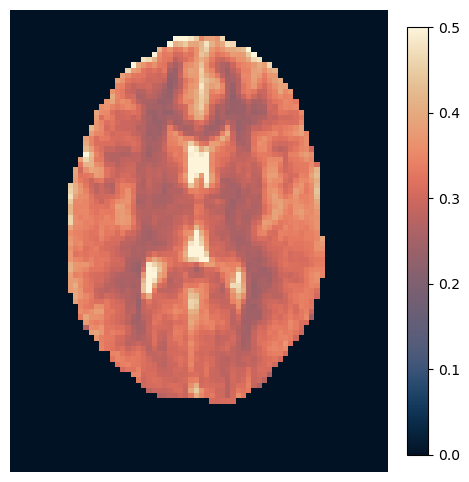

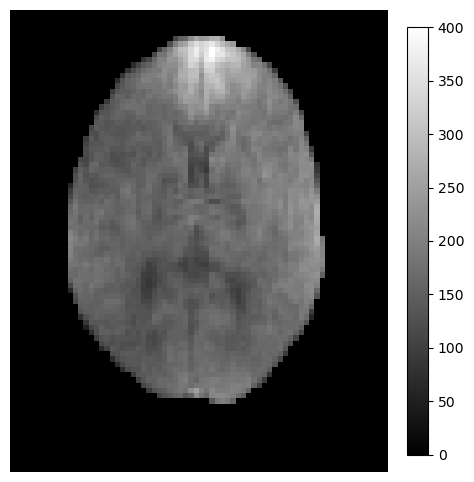

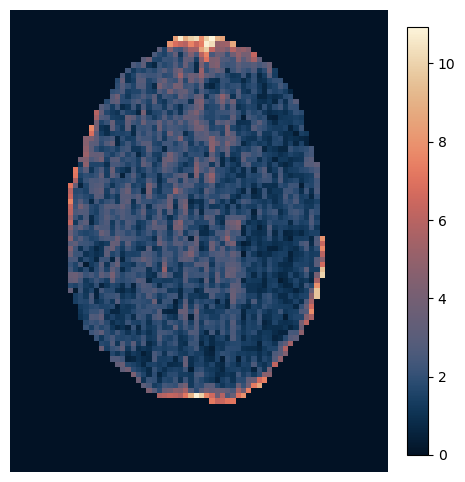

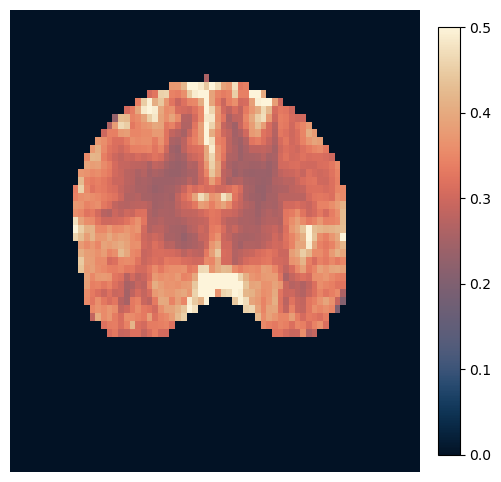

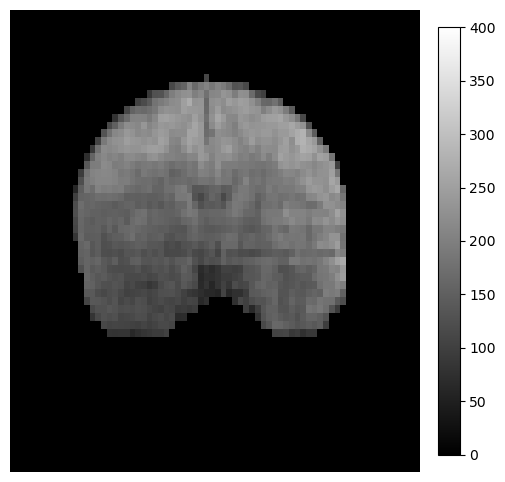

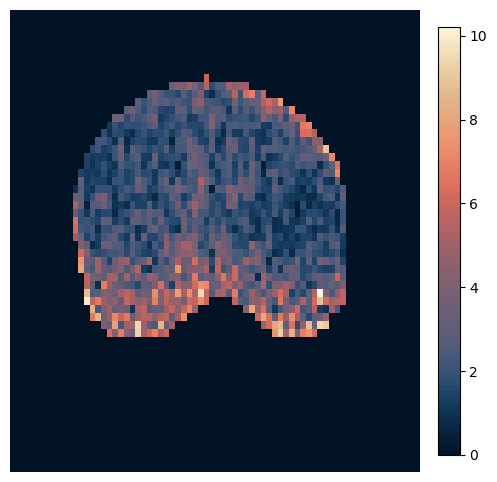

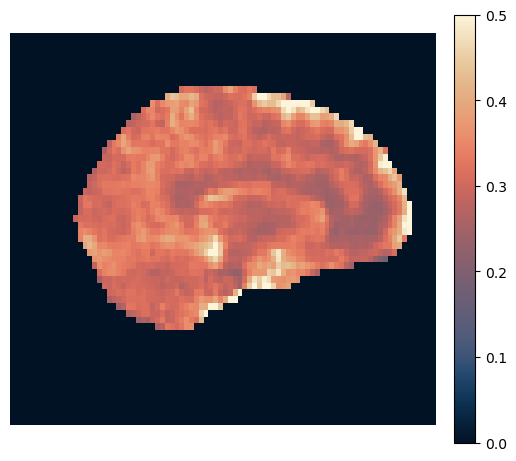

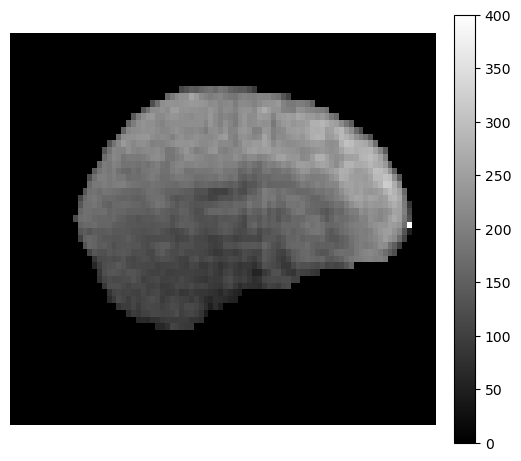

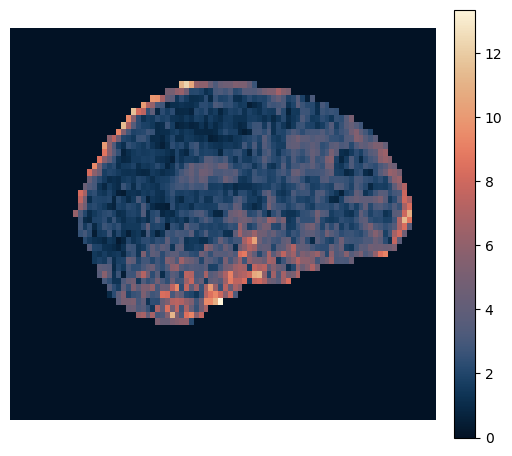

In [6]:
def load_image_data(projdir, pattern):
    file = glob.glob(os.path.join(projdir, f"*{pattern}*"))
    if file:
        img = nib.load(file[0])
        return np.array(img.dataobj)
    else:
        raise FileNotFoundError(f"No file found for pattern: {pattern}")

PROJDIR = '../../path/to/data'

img_T1 = load_image_data(PROJDIR, "LLRV1_IRTSE_T1")
img_PD = load_image_data(PROJDIR, "LLRV1_IRTSE_PD")
img_rms = load_image_data(PROJDIR, "LLRV1_IRTSE_rmse")

plt.style.use('default')


custom_cmap = get_lipari_colormap()
row_titles = ['Axial', 'Sagittal', 'Coronal']
col_titles = ['T1', 'PD', 'RMS']


def show_individual_plot(img, row_title, col_title, slice_idx, cmap, aspect=1, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax, aspect=aspect)
    ax.axis('off')

    # Add a colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Save the figure with an informative filename
    filename = f"{col_title}_{row_title}_slice{slice_idx}.png"

# Axial view
slice_idx = 31
show_individual_plot(np.fliplr(rotate(img_T1[:, :, slice_idx], angle=270)), 'Axial', 'T1', slice_idx, custom_cmap, vmin=0, vmax=0.5)
show_individual_plot(np.fliplr(rotate(img_PD[:, :, slice_idx], angle=270)), 'Axial', 'PD', slice_idx, 'gray', vmin=0, vmax=400)
show_individual_plot(np.fliplr(rotate(img_rms[:, :, slice_idx], angle=270)), 'Axial', 'RMS', slice_idx, custom_cmap)

# Sagittal view 
slice_idx = 35
show_individual_plot(rotate(img_T1[:, slice_idx, :], angle=90), 'Sagittal', 'T1', slice_idx, custom_cmap, aspect=1.4, vmin=0, vmax=0.5)
show_individual_plot(rotate(img_PD[:, slice_idx, :], angle=90), 'Sagittal', 'PD', slice_idx, 'gray', aspect=1.4, vmin=0, vmax=400)
show_individual_plot(rotate(img_rms[:, slice_idx, :], angle=90), 'Sagittal', 'RMS', slice_idx, custom_cmap, aspect=1.4)

# Coronal view 
slice_idx = 31
show_individual_plot(np.fliplr(rotate(img_T1[slice_idx, :, :], angle=90)), 'Coronal', 'T1', slice_idx, custom_cmap, aspect=1.4, vmin=0, vmax=0.5)
show_individual_plot(np.fliplr(rotate(img_PD[slice_idx, :, :], angle=90)), 'Coronal', 'PD', slice_idx, 'gray', aspect=1.4, vmin=0, vmax=400)
show_individual_plot(np.fliplr(rotate(img_rms[slice_idx, :, :], angle=90)), 'Coronal', 'RMS', slice_idx, custom_cmap, aspect=1.4)


## Figure 4

To generate this figure, we need to read both the phantom and the volunteer data, acquired at 6 time points:

In [7]:
def load_in_vivo_data(file_path, structures_to_plot):
    df = pd.read_csv(file_path)
    df = df[(df['StructNameNoSide'].isin(structures_to_plot)) & (df['rec'] == 'LLRv1')]
    df['Pair'] = df.groupby(['StructNameNoSide', 'run', 'acq']).cumcount() // 2 + 1
    return df.groupby(['StructNameNoSide', 'Pair']).agg({'Mean': 'mean', 'Variance': 'mean'}).reset_index()

def load_phantom_data(file_path):
    df = pd.read_csv(file_path, usecols=['LabelValue', 'Mean', 'Variance', 'Quant', 'Segmentation', 'Reconstruction'])
    df = df.query("Reconstruction == 'LLRv1' and Quant == 'T1' and Segmentation == 'T1mimics'")
    
    def extract_tube_data(label):
        subset = df[df['LabelValue'] == label]
        return subset['Mean'].values[-6:], subset['Variance'].values[-6:]  # Select last 6 values

    means_tube_6, variances_tube_6 = extract_tube_data(6)
    means_tube_7, variances_tube_7 = extract_tube_data(7)

    return pd.DataFrame({'Time': range(1, len(means_tube_6) + 1), 
                         'Mean': means_tube_6, 'Variance': variances_tube_6, 'Tube': 'Tube Mimic Cortex'}), \
           pd.DataFrame({'Time': range(1, len(means_tube_7) + 1), 
                         'Mean': means_tube_7, 'Variance': variances_tube_7, 'Tube': 'Tube Mimic White Matter'})




In [ ]:
Once we define those functions, we can proceed to plot:

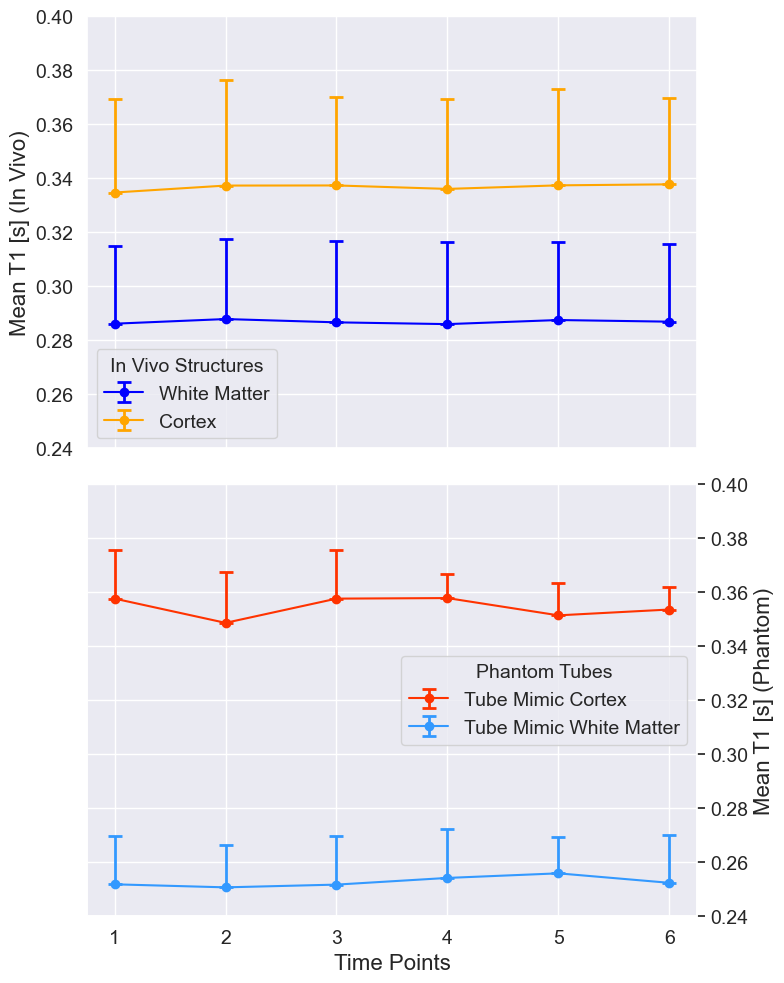

In [9]:
def plot_repeatability(in_vivo_df, phantom_tube_6, phantom_tube_7):
    in_vivo_df['StdDev'] = np.sqrt(in_vivo_df['Variance'])
    phantom_tube_6['StdDev'] = np.sqrt(phantom_tube_6['Variance'])
    phantom_tube_7['StdDev'] = np.sqrt(phantom_tube_7['Variance'])
    structure_names = {'Cerebral-White-Matter': 'White Matter', 'Cerebral-Cortex': 'Cortex'}
    colors = {'White Matter': 'blue', 'Cortex': 'orange', 
              'Tube Mimic White Matter': '#3399ff', 'Tube Mimic Cortex': '#ff3300'}

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
    sns.set_theme()
    
    #Plot in vivo data
    for structure, display_name in structure_names.items():
        subset = in_vivo_df[in_vivo_df['StructNameNoSide'] == structure]
        ax1.errorbar(subset['Pair'], subset['Mean'], yerr=[np.zeros(len(subset)), subset['StdDev']], 
                     fmt='o-', color=colors[display_name], label=display_name, capsize=5, capthick=2, elinewidth=2)
    
    ax1.set_ylabel('Mean T1 [s] (In Vivo)', fontsize=16)
    ax1.legend(title='In Vivo Structures', fontsize=14, title_fontsize=14)
    ax1.grid(True)
    ax1.set_ylim(0.24, 0.40)
    ax1.tick_params(axis='y', labelsize=14)

    # Plot phantom data on a secondary y-axis
    ax2_twin = ax2.twinx()
    ax2_twin.set_ylim(0.24, 0.40)
    
    time_array = np.arange(1, len(phantom_tube_6) + 1)
    ax2_twin.errorbar(time_array, phantom_tube_6['Mean'], yerr=[np.zeros(len(phantom_tube_6)), phantom_tube_6['StdDev']], 
                      fmt='o-', color=colors['Tube Mimic Cortex'], label='Tube Mimic Cortex', capsize=5, capthick=2, elinewidth=2)
    ax2_twin.errorbar(time_array, phantom_tube_7['Mean'], yerr=[np.zeros(len(phantom_tube_7)), phantom_tube_7['StdDev']], 
                      fmt='o-', color=colors['Tube Mimic White Matter'], label='Tube Mimic White Matter', capsize=5, capthick=2, elinewidth=2)

    ax2.set_yticks([])
    ax2_twin.set_ylabel('Mean T1 [s] (Phantom)', fontsize=16)
    ax2_twin.legend(title='Phantom Tubes', fontsize=14, title_fontsize=14)
    ax2_twin.tick_params(axis='y', labelsize=14)
    ax2.grid(True)
    ax2.set_xlabel('Time Points', fontsize=16)
    ax2.tick_params(axis='x', labelsize=14)
    ax2_twin.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
    plt.tight_layout()
    plt.show()

# --- Main ---
if __name__ == "__main__":
    # Define file paths
    in_vivo_file = r'C:\Users\blena\OneDrive - LUMC\Hyperfine\Multisite Paper\stats\repeat\invivo\repeat_invivo_stats.csv'
    phantom_file = r'C:\Users\blena\OneDrive - LUMC\Hyperfine\Multisite Paper\stats\repeat\phantom\repeat_phantom_stats.csv'

    # Load data
    structures = ['Cerebral-White-Matter', 'Cerebral-Cortex']
    in_vivo_df = load_in_vivo_data(in_vivo_file, structures)
    phantom_tube_6, phantom_tube_7 = load_phantom_data(phantom_file)

    # Plot results
    plot_repeatability(in_vivo_df, phantom_tube_6, phantom_tube_7)